In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
rng = np.random.default_rng()
import torch
from torch import nn
import numpy as np
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

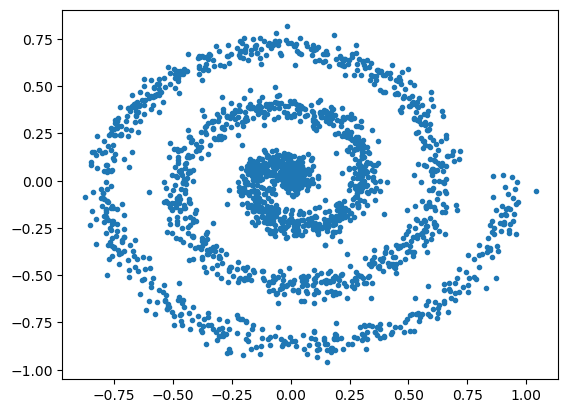

In [2]:
def generate_spiral(*, num: int, rng: np.random.Generator) -> np.ndarray:
    thetas = rng.uniform(low=0.0, high=6*np.pi, size=(num,))
    rs = thetas * 0.05
    X = np.hstack((
        (rs * np.cos(thetas))[:, None],
        (rs * np.sin(thetas))[:, None],
    ))
    X = X + 0.04 * rng.standard_normal(X.shape) 
    return X
spi = generate_spiral(num=2000, rng=rng)
plt.plot(spi[:, 0], spi[:, 1], '.')

In [3]:
spi.shape

(2000, 2)

In [4]:
# Assuming `X` is your NumPy array with the shape (1998, 2)
# For example:
# X = np.random.normal(size=(1998, 2))

# Convert numpy array to tensor and create a DataLoader
tensor_data = torch.tensor(spi, dtype=torch.float32)
val_data = torch.tensor(generate_spiral(num=500, rng=rng), dtype=torch.float32)
data_loader = DataLoader(TensorDataset(tensor_data), batch_size=25, shuffle=True)
val_loader = DataLoader(val_data, batch_size=25, shuffle=False)


# Device configuration
device = torch.device("mps")
device

device(type='mps')

In [5]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [6]:
epochs = 2500
epoch_losses = []
d_losses = []
g_losses = []
generator = Generator(300, 2).to(device)
discriminator = Discriminator(2).to(device)


g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)

In [7]:
for epoch in range(1000):
    for real_data in data_loader:
        real_data = real_data[0].to(device)


        z = torch.randn(real_data.size(0), 300, device=device)
        fake_data = generator(z)

        d_real = discriminator(real_data)
        d_fake = discriminator(fake_data.detach())
        d_loss = -torch.mean(torch.log(d_real) + torch.log(1 - d_fake))

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        g_fake = discriminator(fake_data)
        g_loss = -torch.mean(torch.log(g_fake))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    if (epoch + 1) % 100 == 0:
        epoch_losses.append(epoch + 1)
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        print(f'Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

Epoch 100/2500, D Loss: 1.3784, G Loss: 0.6950
Epoch 200/2500, D Loss: 1.3843, G Loss: 0.7030
Epoch 300/2500, D Loss: 1.3649, G Loss: 0.7203
Epoch 400/2500, D Loss: 1.3680, G Loss: 0.7291
Epoch 500/2500, D Loss: 1.3790, G Loss: 0.7172
Epoch 600/2500, D Loss: 1.4415, G Loss: 0.6064
Epoch 700/2500, D Loss: 1.3938, G Loss: 0.5826
Epoch 800/2500, D Loss: 1.3788, G Loss: 0.8831
Epoch 900/2500, D Loss: 1.2398, G Loss: 0.7233
Epoch 1000/2500, D Loss: 1.3543, G Loss: 0.6910


In [13]:
epl=[]
for j in range(10):
    epl.append(100*(j+1))
epl    

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

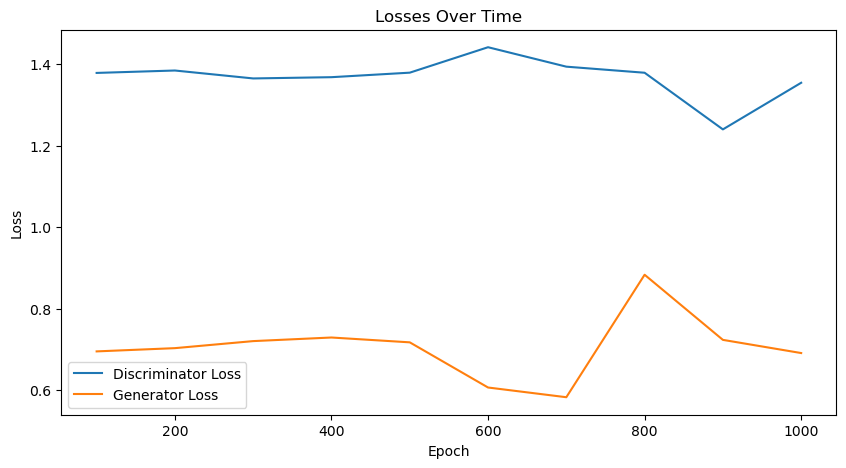

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(epl,d_losses, label='Discriminator Loss')
plt.plot(epl,g_losses, label='Generator Loss')
plt.title('Losses Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

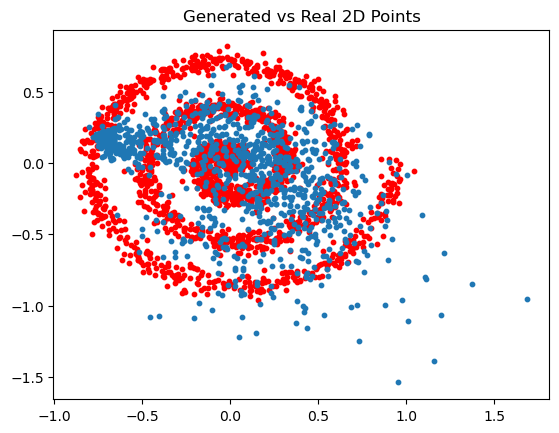

In [15]:
z = torch.randn(1000, 300, device=device)
generated_points = generator(z).detach().cpu().numpy()
plt.scatter(spi[:, 0], spi[:, 1], s=10, c='red')  
plt.scatter(generated_points[:, 0], generated_points[:, 1], s=10)
plt.title('Generated vs Real 2D Points')
plt.show()

In [17]:
torch.save(generator, 'GAN_spi_gen.pth')
torch.save(Discriminator, 'GAN_spi_disc.pth')

In [38]:
model = torch.load('GAN_spi_gen.pth')
model.eval()  

Generator(
  (net): Sequential(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [41]:
z = torch.randn(1000, 300, device=device)
generated_points = model(z).detach().cpu().numpy()
generated_points

array([[-0.14891097,  0.07649451],
       [-0.5011054 ,  0.67818016],
       [ 0.24858987,  0.17641607],
       ...,
       [-0.17145029,  0.06907113],
       [ 0.7936537 , -0.40200445],
       [ 0.5891586 , -0.06944524]], dtype=float32)

In [43]:
np.save("GAN_spiral.npy",generated_points)